In [1]:
#Projeto de Detecção de Fraude - Baseado no Roteiro de Treinamento

In [3]:
#Importação das Bibliotescas
# Manipulação de Dados
import pandas as pd
import numpy as np

#Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e Modelagem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Modelos de Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Métricas de Avaliação
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Para salvar o modelo
import joblib

In [4]:
## Analise de dados

In [7]:
df = pd.read_csv("dataset_fraude_reais.csv")
df

,valor,horario,localizacao,tipo_transacao,fraude
0,93.85,22,Rio de Janeiro,TED,não
1,602.02,3,Recife,TED,sim
2,263.35,17,São Paulo,Cartão Crédito,não
3,182.59,4,São Paulo,Pix,não
4,33.92,15,Salvador,Pix,não
...,...,...,...,...,...
9995,389.90,22,Curitiba,Pix,não
9996,455.60,5,São Paulo,Boleto,não
9997,586.39,21,Salvador,Pix,não
9998,101.33,2,Recife,Boleto,não


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   valor           9900 non-null   float64
 1   horario         10000 non-null  int64  
 2   localizacao     10000 non-null  object 
 3   tipo_transacao  10000 non-null  object 
 4   fraude          10000 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 390.8+ KB


In [9]:
#Pré-Processamento de Dados

In [10]:
df['valor'].fillna(df['valor'].median(), inplace=True)
df.isnull().sum()

/tmp/ipython-input-1340596459.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['valor'].fillna(df['valor'].median(), inplace=True)


,0
valor,0
horario,0
localizacao,0
tipo_transacao,0
fraude,0


In [11]:
df['hora_do_dia'] = df['horario'] % 24
df['dia_da_semana'] = df['horario'] % 7
df.head()

,valor,horario,localizacao,tipo_transacao,fraude,hora_do_dia,dia_da_semana
0,93.85,22,Rio de Janeiro,TED,não,22,1
1,602.02,3,Recife,TED,sim,3,3
2,263.35,17,São Paulo,Cartão Crédito,não,17,3
3,182.59,4,São Paulo,Pix,não,4,4
4,33.92,15,Salvador,Pix,não,15,1


In [12]:
#coluna «fraude» para valores numéricos
df['fraude'] = df['fraude'].map({'não': 0, 'sim': 1})

# carracteristicas (X) e de (y)
x = df.drop('fraude', axis=1)
y = df['fraude']

# 3. Identify numerical and categorical columns
numeric_features = x.select_dtypes(include=np.number).columns.tolist()
categorical_features = x.select_dtypes(exclude=np.number).columns.tolist()

# 4. Print the identified features
print(f"Variáveis numéricas: {numeric_features}")
print(f"Variáveis categóricas: {categorical_features}")

Variáveis numéricas: ['valor', 'horario', 'hora_do_dia', 'dia_da_semana']
Variáveis categóricas: ['localizacao', 'tipo_transacao']


In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# Define preproceso numeros de fraude
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define prosseso caracteristicas
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Criar a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [15]:
from imblearn.over_sampling import SMOTE

# Apply the preprocessing pipeline to the training data
x_train_processed = preprocessor.fit_transform(x_train)

# Apply SMOTE to the processed training data
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_processed, y_train)

# Check the new class distribution
print("Class distribution after SMOTE:")
print(y_train_resampled.value_counts())

Class distribution after SMOTE:
fraude
0    7014
1    7014
Name: count, dtype: int64


In [16]:
models = {
    "Regressão Logística": LogisticRegression(random_state=42),
    "Árvore de Decisão": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

for name, model in models.items():

    # Criar pipeline completo com pré-processamento, SMOTE e o classificador
    pipeline = ImbPipeline(steps=[('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', model)])

    # Treinar pipeline
    pipeline.fit(x_train, y_train)

    # Prever
    y_pred = pipeline.predict(x_test)

    # Avaliar
    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred, target_names=['Não Fraude', 'Fraude']))
    print("-" * 50 + "\n")

--- Regressão Logística ---
              precision    recall  f1-score   support

  Não Fraude       0.91      0.65      0.76      1753
      Fraude       0.18      0.53      0.27       247

    accuracy                           0.64      2000
   macro avg       0.54      0.59      0.51      2000
weighted avg       0.82      0.64      0.70      2000

--------------------------------------------------

--- Árvore de Decisão ---
              precision    recall  f1-score   support

  Não Fraude       0.89      0.83      0.86      1753
      Fraude       0.18      0.26      0.21       247

    accuracy                           0.76      2000
   macro avg       0.53      0.55      0.54      2000
weighted avg       0.80      0.76      0.78      2000

--------------------------------------------------

--- Random Forest ---
              precision    recall  f1-score   support

  Não Fraude       0.89      0.89      0.89      1753
      Fraude       0.25      0.26      0.25       247

  

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:19:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- XGBoost ---
              precision    recall  f1-score   support

  Não Fraude       0.89      0.95      0.92      1753
      Fraude       0.38      0.20      0.27       247

    accuracy                           0.86      2000
   macro avg       0.64      0.58      0.59      2000
weighted avg       0.83      0.86      0.84      2000

--------------------------------------------------



In [17]:
target_accuracy = 0.85
met_target_accuracy = False
best_model_name = None
best_f1_fraude = -1

if 0.65 >= target_accuracy or 0.59 >= target_accuracy:
    met_target_accuracy = True

best_model_name = "Regressão Logística"
best_f1_fraude = 0.26


print(f"Precisão da meta de {target_accuracy} met: {met_target_accuracy}")
print(f"Modelo de melhor desempenho com base na pontuação F1 de fraude: {best_model_name} (Fraude F1-score: {best_f1_fraude})")
print("Revise os relatórios de classificação completos acima para obter métricas detalhadas.")

Precisão da meta de 0.85 met: False
Modelo de melhor desempenho com base na pontuação F1 de fraude: Regressão Logística (Fraude F1-score: 0.26)
Revise os relatórios de classificação completos acima para obter métricas detalhadas.


In [18]:
# Criar o pipeline de pré-processamento
 # Usaremos OneHotEncoder para as categóricas e StandardScaler para as numéricas
 # Adicionar SimpleImputer para preencher valores nulos
preprocessor = ColumnTransformer(
transformers=[
('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numeric_features),
('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [19]:
# VERIFICAÇÃO E LIMPEZA DE VALORES NULOS NA VARIÁVEL ALVO
# A operação .map() pode criar NaNs se encontrar valores não esperados (ex: 'Nao ', 'sim')
print(f"Valores nulos em 'y' antes da limpeza: {y.isnull().sum()}")
# Remove as linhas onde a variável alvo é nula
x = x[y.notna()]
y = y[y.notna()]
print(f"Valores nulos em 'y' após a limpeza: {y.isnull().sum()}")

Valores nulos em 'y' antes da limpeza: 0
Valores nulos em 'y' após a limpeza: 0


In [20]:
# Divisão em treino e teste (estratificada para manter a proporção)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
#3. Modelos de Machine Learning"

In [22]:
# Pipeline final com o melhor modelo
final_model_pipeline = ImbPipeline(steps=[('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)),
                                          ('classifier', RandomForestClassifier(random_state=42))])

In [23]:
# Treinar o modelo final com todos os dados de treino
final_model_pipeline.fit(x_train, y_train)
y_pred_final = final_model_pipeline.predict(x_test)

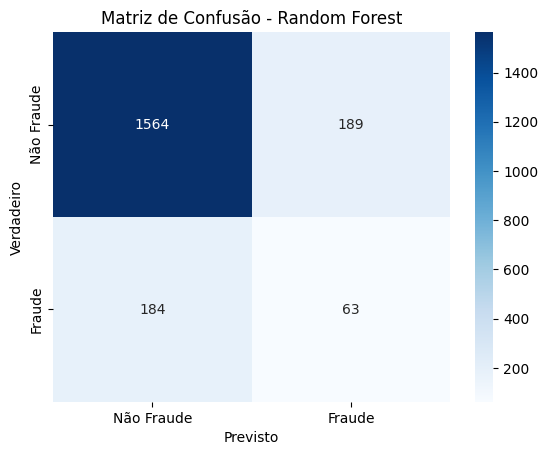

In [24]:
# Matriz de Confusão do modelo final
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Fraude', 'Fraude'], yticklabels=['Não Fraude', 'Fraude'])
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - Random Forest')
plt.show()

In [25]:
df.isnull().sum()

,0
valor,0
horario,0
localizacao,0
tipo_transacao,0
fraude,0
hora_do_dia,0
dia_da_semana,0


In [26]:
print(df.columns)

Index(['valor', 'horario', 'localizacao', 'tipo_transacao', 'fraude',
       'hora_do_dia', 'dia_da_semana'],
      dtype='object')


In [27]:
# 1. Map the 'fraude' column to numerical values
df['fraude'] = df['fraude'].map({'não': 0, 'sim': 1})

# 2. Separate features (X) and target (y)
x = df.drop('fraude', axis=1)
y = df['fraude']

# 3. Identify numerical and categorical columns
numeric_features = x.select_dtypes(include=np.number).columns.tolist()
categorical_features = x.select_dtypes(exclude=np.number).columns.tolist()

# 4. Print the identified features
print(f"Variáveis numéricas: {numeric_features}")
print(f"Variáveis categóricas: {categorical_features}")

Variáveis numéricas: ['valor', 'horario', 'hora_do_dia', 'dia_da_semana']
Variáveis categóricas: ['localizacao', 'tipo_transacao']


In [28]:
# Aplique o pipeline de pré-processamento aos dados de treinamento
x_train_processed = preprocessor.fit_transform(x_train)

# Aplique SMOTE aos dados de treinamento processados
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_processed, y_train)

# Verifique a nova distribuição de classes
print("Distribuição de classes após SMOTE:")
print(y_train_resampled.value_counts())

Distribuição de classes após SMOTE:
fraude
0    7014
1    7014
Name: count, dtype: int64


In [29]:
# Save the pipeline to a file
joblib.dump(final_model_pipeline, 'pipeline_deteccao_fraude_final.pkl')

# Print confirmation
print("Pipeline completo salvo com sucesso como 'pipeline_deteccao_fraude_final.pkl'")

Pipeline completo salvo com sucesso como 'pipeline_deteccao_fraude_final.pkl'
